In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import collections, time, spacy, copy, string, re, json, matplotlib
from layers.bert_plus_bidaf import BERT_plus_BiDAF
from eval_test import evaluate, compare
from utils import data_processing
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from training import SquadDataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
val_encodings = torch.load(r'D:\OneDrive\Courses\ECS289 NLP\val_encodings.pt')
val_answer=torch.load(r'D:\OneDrive\Courses\ECS289 NLP\val_answer.pt')
val_dataset = SquadDataset(val_encodings)

In [4]:
nlp = spacy.blank("en")
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [5]:
model = BERT_plus_BiDAF(if_extra_modeling=True, if_attention_map=True)
model.load_state_dict(torch.load(r'D:\OneDrive\Courses\ECS289 NLP\trained_model.pt'))

<All keys matched successfully>

In [6]:
idx = 0
model.to(device)
model.eval()

BERT_plus_BiDAF(
  (bert_layer): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
           

In [7]:
with torch.no_grad():
    input_ids = torch.unsqueeze(val_dataset[idx]['input_ids'], dim=0).to(device)
    attention_mask = torch.unsqueeze(val_dataset[idx]['attention_mask'], dim=0).to(device)
    outputs = model(input_ids, attention_mask)
weight_c2q = outputs[3]
weight_q2c = outputs[4]

In [9]:
print(weight_c2q.shape, weight_q2c.shape)

torch.Size([1, 450, 62]) torch.Size([1, 450])


In [20]:
question_ids = input_ids[:,1:63].squeeze(0)
context_ids = torch.cat((input_ids[:,0].unsqueeze(0), input_ids[:,63:]), dim = 1).squeeze(0)
print(question_ids.shape, context_ids.shape)

torch.Size([62]) torch.Size([450])


In [21]:
question_tokens = tokenizer.convert_ids_to_tokens(question_ids)
context_tokens = tokenizer.convert_ids_to_tokens(context_ids)

In [33]:
def getLen(token_list):
    for i, token in enumerate(token_list):
        if token == '[PAD]':
            return i

In [34]:
question_len = getLen(question_tokens)
context_len = getLen(context_tokens)

7 158


In [25]:
weight_c2q_np = weight_c2q.squeeze(0).cpu().numpy()

(450, 62)


In [38]:
question_tokens = question_tokens[0:question_len]
context_tokens = context_tokens[0:context_len]
weight_c2q_np = weight_c2q_np[0:context_len, 0:question_len]

In [48]:
print(weight_c2q_np.shape)
weight_c2q_np = weight_c2q_np / np.sum(weight_c2q_np, axis=1)[:,None]

(158, 7)
1.0


In [26]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar
def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

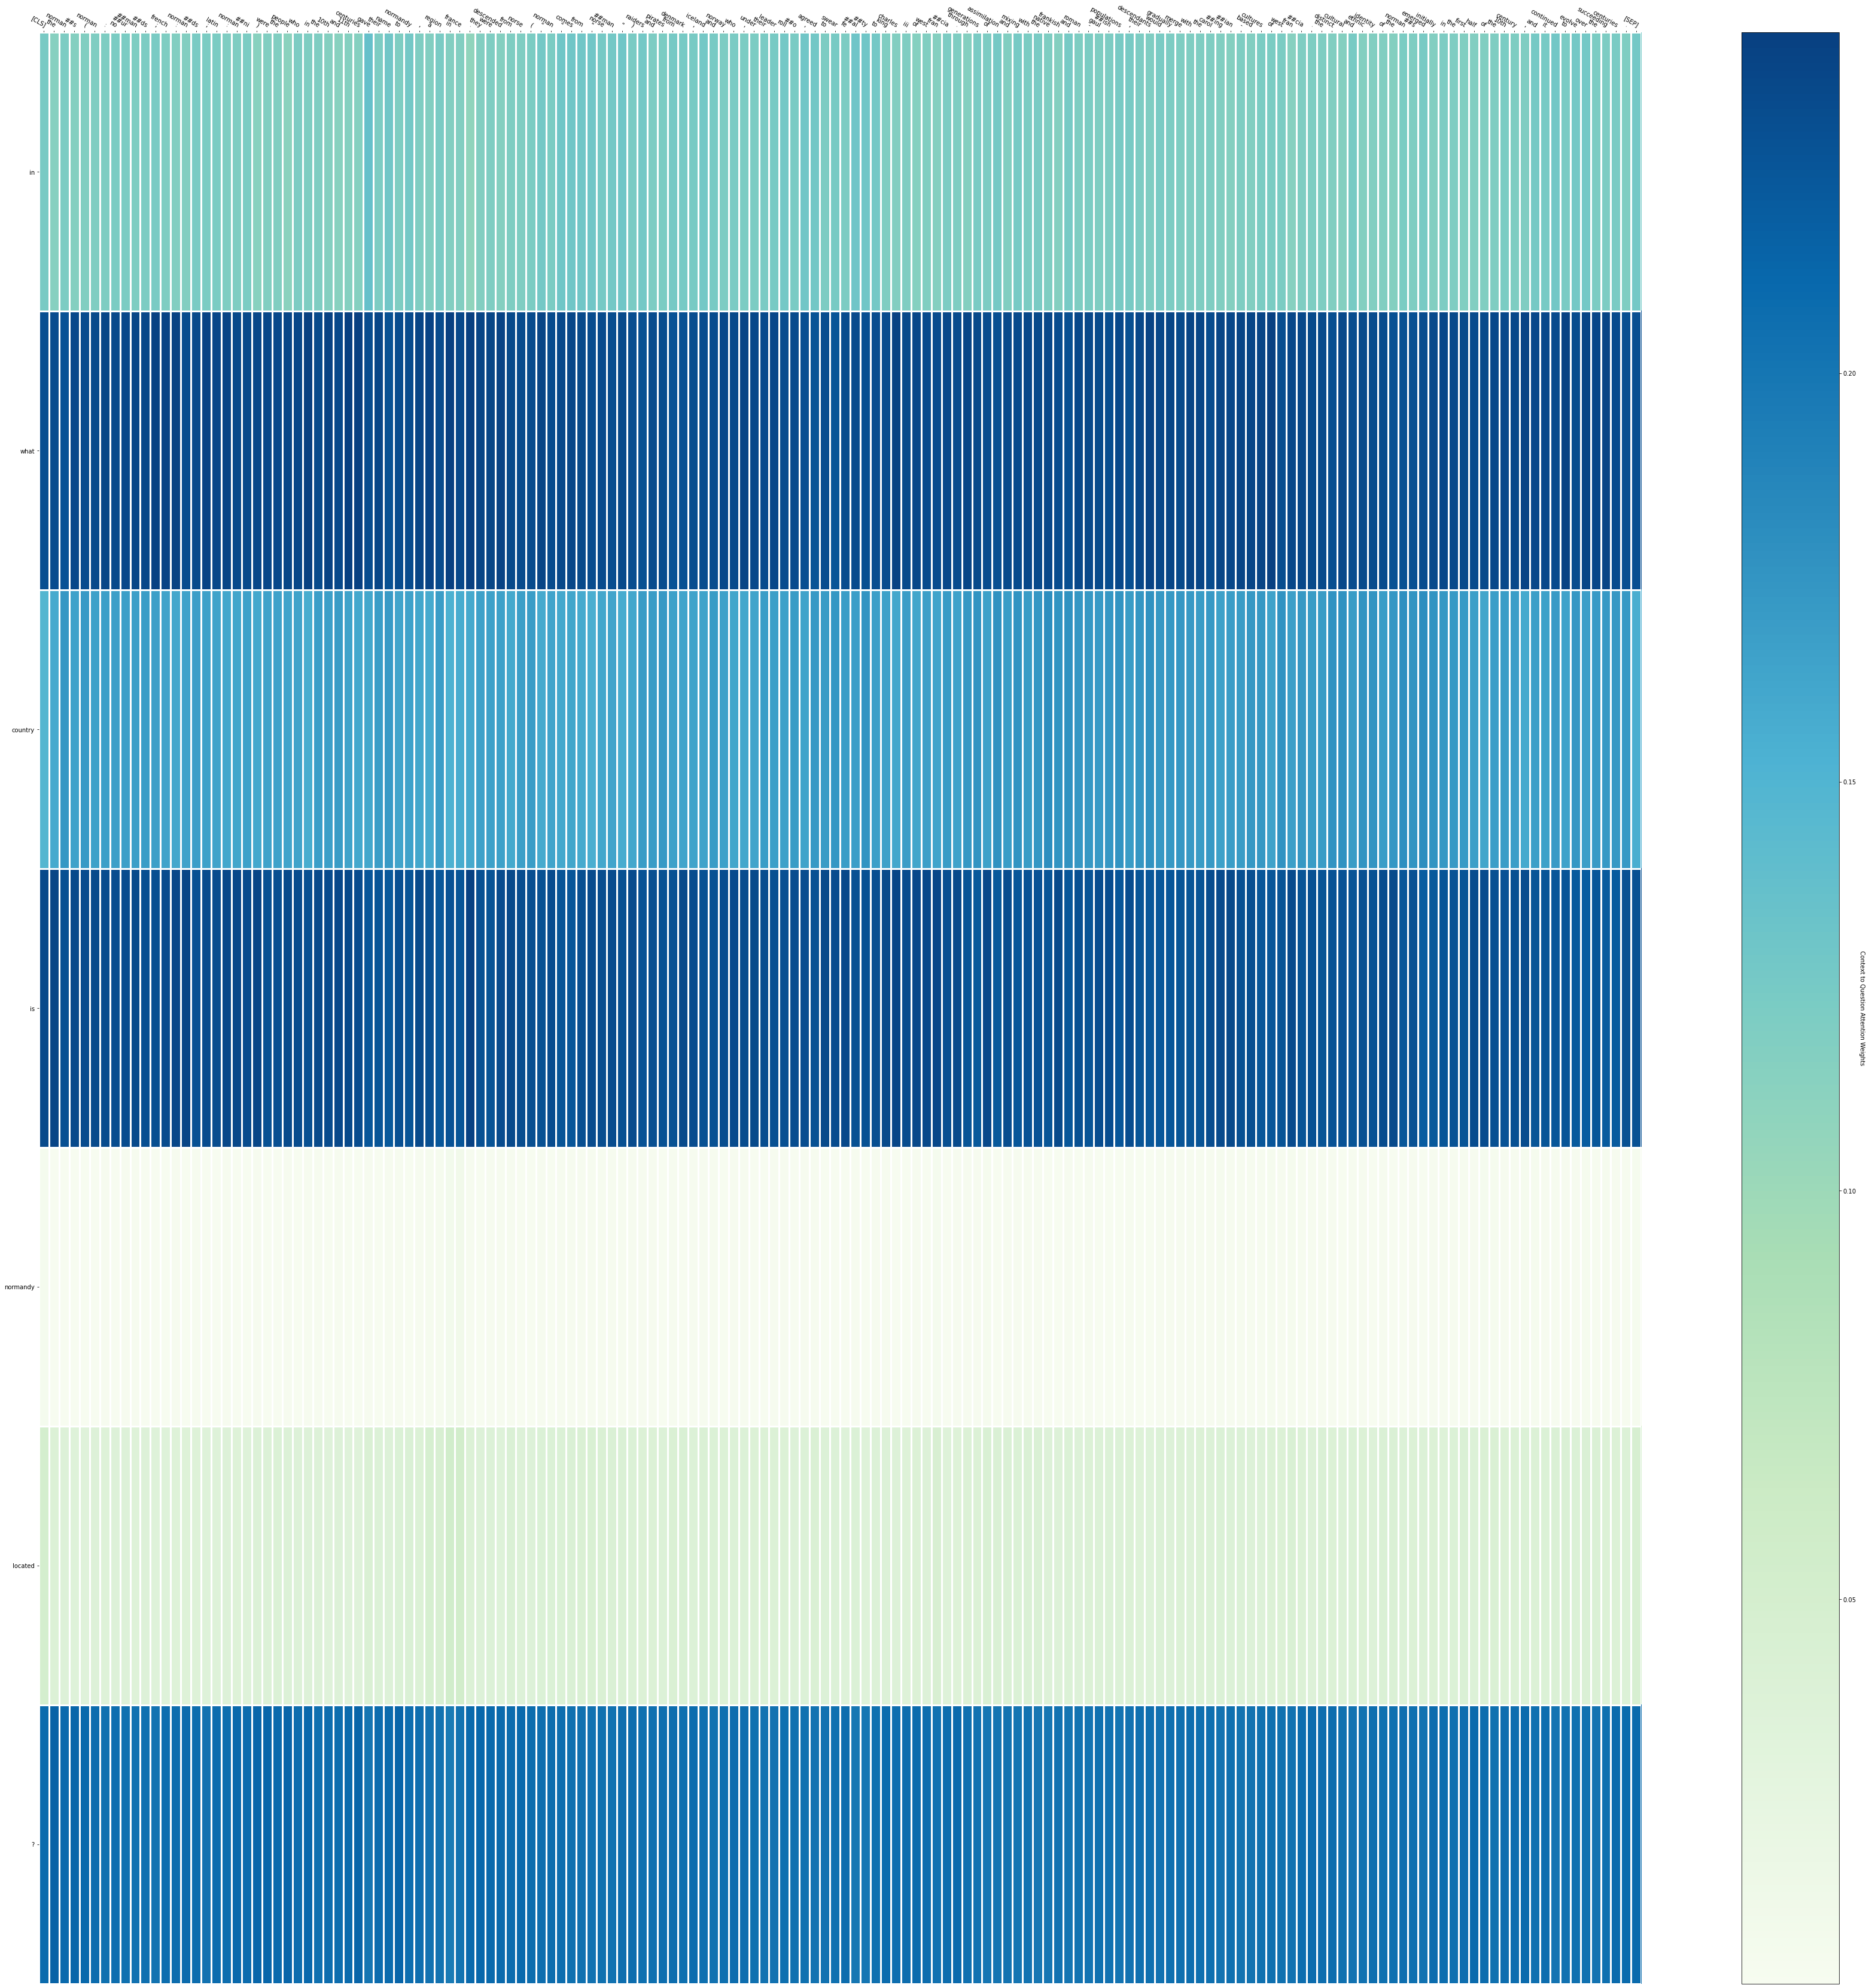

In [93]:
fig, ax = plt.subplots(figsize = (60,60))
im, cbar = heatmap(weight_c2q_np.T, question_tokens, context_tokens, ax = ax, cmap = "GnBu", cbarlabel='Context to Question Attention Weights', aspect = 'auto')
# texts = annotate_heatmap(im, valfmt='{x:.2f}')
plt.savefig('C2Q_weights.jpeg', dpi=300, optimize=True)
plt.show()

In [63]:
weight_q2c.shape

torch.Size([1, 450])

In [74]:
weight_q2c_np = weight_q2c.cpu().numpy()[:,0:context_len]

In [75]:
print(weight_q2c_np.shape)

(1, 158)


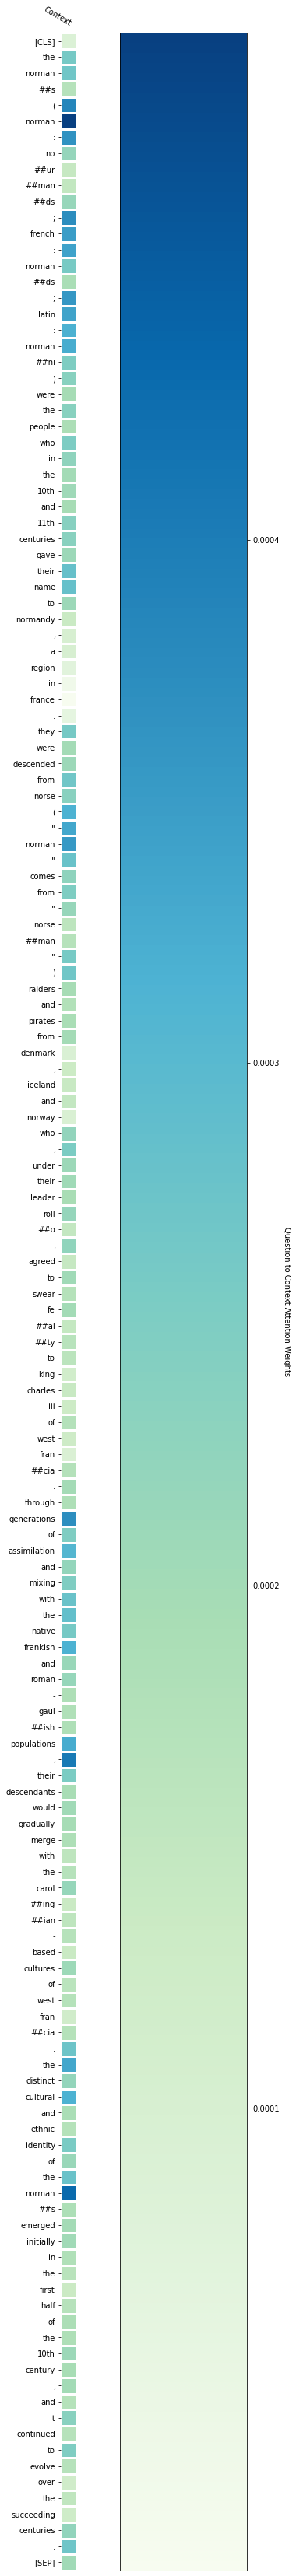

In [97]:
fig, ax = plt.subplots(figsize = (20,60))
im, cbar = heatmap(weight_q2c_np.T, context_tokens, ['Context'], ax = ax, cmap = "GnBu", cbarlabel='Question to Context Attention Weights', aspect = 'equal')
# texts = annotate_heatmap(im, valfmt='{x:.2f}')
plt.savefig('Q2C_weights.jpeg', dpi=300, optimize=True)
plt.show()

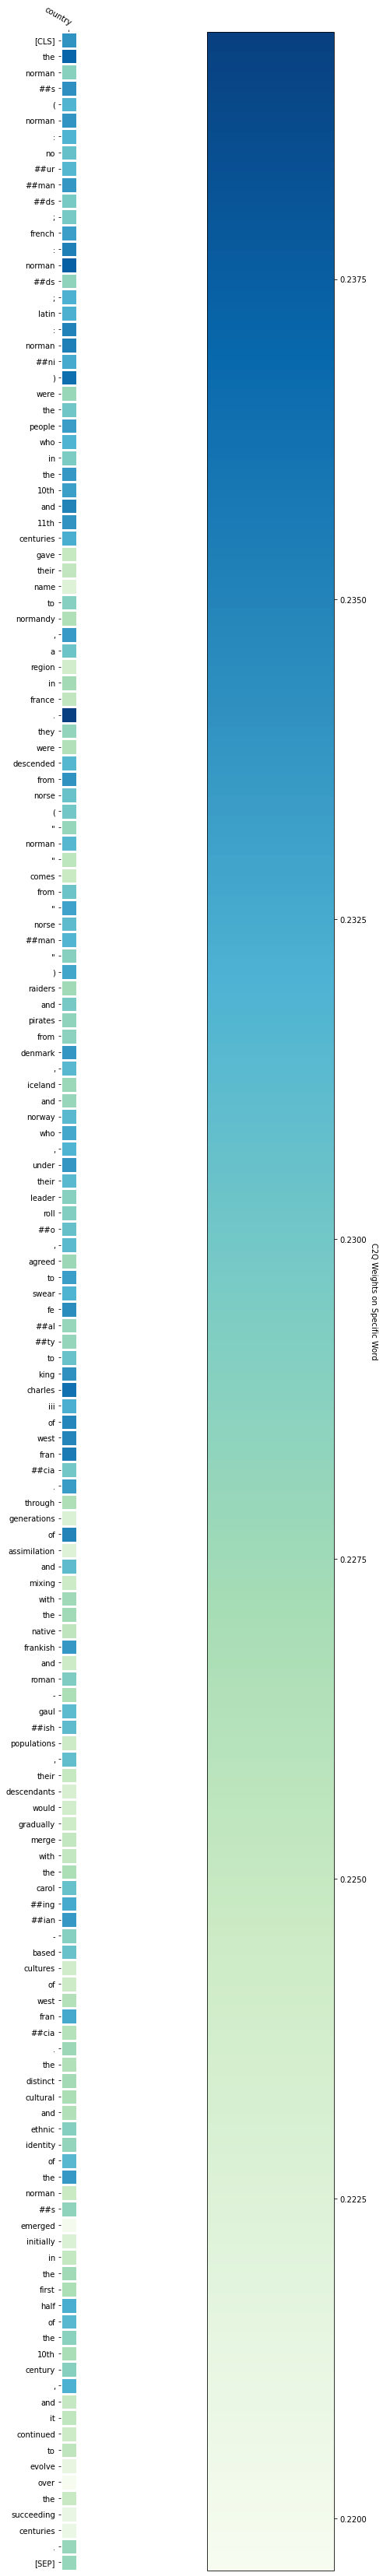

In [85]:
weight_country = np.expand_dims(weight_c2q_np[:,3], axis=1)
fig, ax = plt.subplots(figsize = (60,60))
im, cbar = heatmap(weight_country, context_tokens, ['country'], ax = ax, cmap = "GnBu", cbarlabel='C2Q Weights on Specific Word', aspect = 'equal')
# texts = annotate_heatmap(im, valfmt='{x:.2f}')
plt.show()